In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl
import sys
import math
sys.path.append('../../')
from data.processing import get_data
import models
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets, plot_cv_in_params, plot_recovery_loss, plot_confidence_interval
import yaml
from data.dataloader import SimulatedDataLoader

In [3]:
def update_hosp_ratios(param_set, data_config, model_config):
    df = pd.read_csv(os.path.join('../../data/data/simulated_data/', data_config['output_file_name']), index_col=0)
    if model_config['end_date']:
        # print(model_config['end_date'])
        if isinstance(model_config['end_date'], int):
            if end_date > 0:
                raise ValueError('Please enter a negative value for end_date if entering an integer')
        if isinstance(model_config['end_date'], datetime.date):
            df['date'] = pd.to_datetime(df['date'])
            end_date = df.loc[df['date'].dt.date == model_config['end_date']].index[0] - len(df) + 1
    else:
        end_date = 0
    train_start_row = df.iloc[len(df) - (model_config['train_period'] + model_config['val_period'] + model_config['test_period']) + end_date]
    if data_config['model'] == 'SEIRHD':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
    elif data_config['model'] == 'SEIRHD_Beta':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
    elif data_config['model'] == 'SEIR_PU':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
        param_set['Pu_pop_ratio'] = train_start_row['Pu'] / train_start_row['']
    return param_set

# Create short pickle file

In [6]:
save_dir = '../../misc/predictions/exp2' 
file_name = 'exp2_trial1.pickle'
with open(os.path.join(save_dir, file_name), 'rb') as handle:
    input_dict = pkl.load(handle)

In [26]:
input_dict['train_periods']

[28, 70]

In [7]:
output = []
for pred in input_dict['predictions_dicts']:
    pd_output = {}
    pd_output['prediction_dict'] = {}
    pd_output['prediction_dict']['best_params'] = pred['prediction_dict']['best_params']
    pd_output['prediction_dict']['df_loss'] = pred['prediction_dict']['df_loss']
    pd_output['run_tuple'] = pred['run_tuple']
    # pd['trials'] = pd['prediction_dict']['trials']
    # del pd['prediction_dict']
    output.append(pd_output)

In [9]:
output_dict = {}
output_dict['predictions_dicts'] = output
output_dict['model_config'] = input_dict['model_config']
output_dict['val_periods'] = input_dict['val_periods']
output_dict['train_periods'] = input_dict['train_periods']
output_dict['end_dates'] = input_dict['end_dates']
with open(os.path.join(save_dir, "exp2_trial1_short.pickle"), 'wb') as handle:
    pkl.dump(output_dict, handle)

## Plots

In [4]:
save_dir = '../../misc/predictions/exp2' 
file_name = 'exp2_trial1_short.pickle'
with open(os.path.join(save_dir, file_name), 'rb') as handle:
    run_dict = pkl.load(handle)

In [5]:
model_config = run_dict['model_config']
simulated_config_filename = model_config['data']['dataloading_params']['config_file']
with open(os.path.join("../../configs/simulated_data/", simulated_config_filename)) as configfile:
    simulated_config = yaml.load(configfile, Loader=yaml.SafeLoader)    
actual_params = simulated_config['params']
del actual_params['N']

In [6]:
val_periods = run_dict['val_periods']
end_dates = run_dict['end_dates'] 
format_str = '%d-%m-%Y' # The format

In [7]:
plot_dict = {}
for which_loss in ['train', 'val'] :
    plot_dict[which_loss] = {}
    for end_date in end_dates :
        end_date = datetime.datetime.strptime(end_date,format_str).date()
        plot_dict[which_loss][end_date] = {}
        for val in val_periods :
            plot_dict[which_loss][end_date][val] = []

In [8]:
def mape_loss(pred,true):
    return (abs(pred-true)/true)*100

def calc_loss(pred,true,method='mape'):
    if method == 'mape':
        return mape_loss(pred,true)

def compute_losses(best_params,true_params,method='mape'):
    losses = {}
    for param in best_params:
        losses[param] = calc_loss(best_params[param],true_params[param],method)
    return losses

In [19]:
train_period = 28
for run in run_dict['predictions_dicts'] : 
    run_tuple = run['run_tuple']
    if(run_tuple['train'] != train_period):
        continue
    # pred = run['prediction_dict']
    # best_params = pred['best_params']
    # model_config['split']['end_date'] = run_tuple['end_date']
    # model_config['split']['train_period'] = run_tuple['train']
    # model_config['split']['val_period'] = run_tuple['val']
    # true_params = update_hosp_ratios(actual_params, simulated_config, model_config['split'])
    # losses = compute_losses(best_params,true_params)
    losses = run['prediction_dict']['df_loss']
    for which_loss in ['train', 'val'] :
        plot_dict[which_loss][run_tuple['end_date']][run_tuple['val']].append(np.mean(losses[which_loss]))

In [22]:
for which_loss in ['train', 'val'] : 
    for end_date in end_dates :
        end_date = datetime.datetime.strptime(end_date,format_str).date()
        for val in val_periods : 
            losses = np.array(plot_dict[which_loss][end_date][val])
            plot_dict[which_loss][end_date][val] = np.mean(losses)

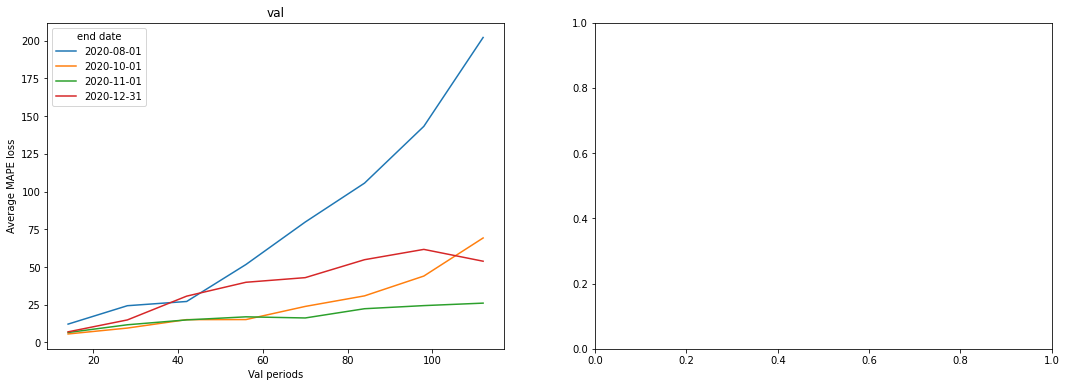

In [29]:
n_subplots = 1
ncols = 2
nrows = math.ceil(n_subplots/ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(18, 6*nrows))
ax_counter = 0
which_loss = 'val'
loss_dict = plot_dict[which_loss]
ax = axs.flat[ax_counter]
for end_date, end_date_dict in loss_dict.items():
    ax.plot(list(end_date_dict.keys()), list(end_date_dict.values()), label=end_date)
ax_counter += 1
ax.set_title(which_loss)
ax.set_xlabel("Val periods")
ax.set_ylabel("Average MAPE loss")
ax.legend(title="end date")